In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lol-dataset/lol_dataset/eval15/low/780.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/778.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/493.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/669.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/547.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/55.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/1.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/748.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/22.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/146.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/179.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/665.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/23.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/111.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/79.png
/kaggle/input/lol-dataset/lol_dataset/eval15/high/780.png
/kaggle/input/lol-dataset/lol_dataset/eval15/high/778.png
/kaggle/input/lol-dataset/lol_datas

# Import Libraries

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import plot_model, img_to_array

E0000 00:00:1741246770.607955   97922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741246770.614509   97922 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16320481265991259557
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2730426368
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11205400922558400547
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


I0000 00:00:1741246773.804228   97922 gpu_device.cc:2022] Created device /device:GPU:0 with 2603 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


# Load Data

In [3]:
high_light_train_images_path = "../../data/lol_dataset/our485/high"
low_light_train_images_path = "../../data/lol_dataset/our485/low"

high_light_test_images_path = "../../data/lol_dataset/our485/high"
low_light_test_images_path = "../../data/lol_dataset/our485/low"

In [4]:
SIZE = 256

In [5]:
def load_images(path, size=224, count=None):
    if count == None:
        files = os.listdir(path)
    else:
        files = os.listdir(path)[:count]
    images = []

    for file in tqdm.tqdm(files):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (size, size))
        img = img.astype("float32") / 255.
        img = img_to_array(img)
        images.append(img)

    images = np.array(images)
    return images

In [6]:
train_low_images = load_images(low_light_train_images_path, size=SIZE)

100%|██████████| 485/485 [00:02<00:00, 175.68it/s]


In [7]:
train_high_images = load_images(high_light_train_images_path, size=SIZE)

100%|██████████| 485/485 [00:02<00:00, 173.13it/s]


In [8]:
test_low_images = load_images(low_light_test_images_path, size=SIZE)

100%|██████████| 485/485 [00:02<00:00, 181.47it/s]


In [9]:
test_high_images = load_images(high_light_test_images_path, size=SIZE)

100%|██████████| 485/485 [00:02<00:00, 166.37it/s]


# Visualization

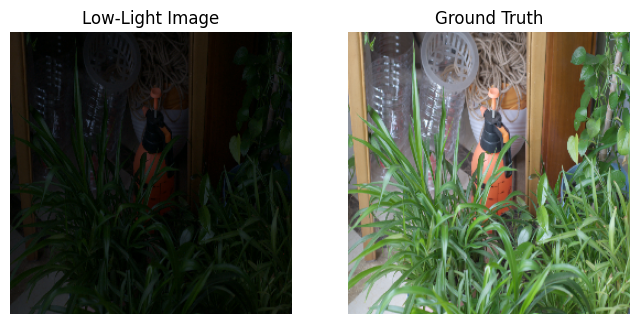

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

axes[0].imshow(train_low_images[10])
axes[0].set_title("Low-Light Image")
axes[0].axis("off")

axes[1].imshow(train_high_images[10])
axes[1].set_title("Ground Truth")
axes[1].axis("off")

plt.show()

# Model

In [11]:
def down_block(x, filters, kernel_size, apply_batch_normalization=True):
    x = layers.Conv2D(filters, kernel_size, padding="same", strides=2)(x)
    if apply_batch_normalization:
        x = layers.BatchNormalization()(x)

    x = layers.LeakyReLU()(x)
    return x

In [12]:
def up_block(x, skip, filters, kernel_size, dropout=False):
    x = layers.Conv2DTranspose(filters, kernel_size, padding="same", strides=2)(x)
    if dropout:
        x = layers.Dropout(0.1)(x)

    x = layers.LeakyReLU()(x)
    x = layers.concatenate([x, skip])
    return x

In [13]:
def build_model(size):
    inputs = layers.Input(shape=[size, size, 3])

    # Downsampling
    d1 = down_block(inputs, 128, (3, 3), apply_batch_normalization=False)
    d2 = down_block(d1, 128, (3, 3), apply_batch_normalization=False)
    d3 = down_block(d2, 256, (3, 3), apply_batch_normalization=True)
    d4 = down_block(d3, 512, (3, 3), apply_batch_normalization=True)
    d5 = down_block(d4, 512, (3, 3), apply_batch_normalization=True)

    # Upsampling
    u1 = up_block(d5, d4, 512, (3, 3), dropout=False)
    u2 = up_block(u1, d3, 256, (3, 3), dropout=False)
    u3 = up_block(u2, d2, 128, (3, 3), dropout=False)
    u4 = up_block(u3, d1, 128, (3, 3), dropout=False)

    # Final upsampling
    u5 = layers.Conv2DTranspose(64, (3, 3), padding='same', strides=2)(u4)
    u5 = layers.LeakyReLU()(u5)
    u5 = layers.concatenate([u5, inputs])

    # Output layer
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid', padding='same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model = build_model(size=SIZE)

I0000 00:00:1741246789.209583   97922 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2603 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,584 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │    147,584 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    295,168 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,359,808 │ leaky_re_lu_4[0]… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ leaky_re_lu_5[0]… │
│ (Concatenate)       │ 1024)             │            │ leaky_re_lu_3[0]

 Total params: 9,743,500 (37.17 MB)

 Trainable params: 9,740,940 (37.16 MB)

 Non-trainable params: 2,560 (10.00 KB)

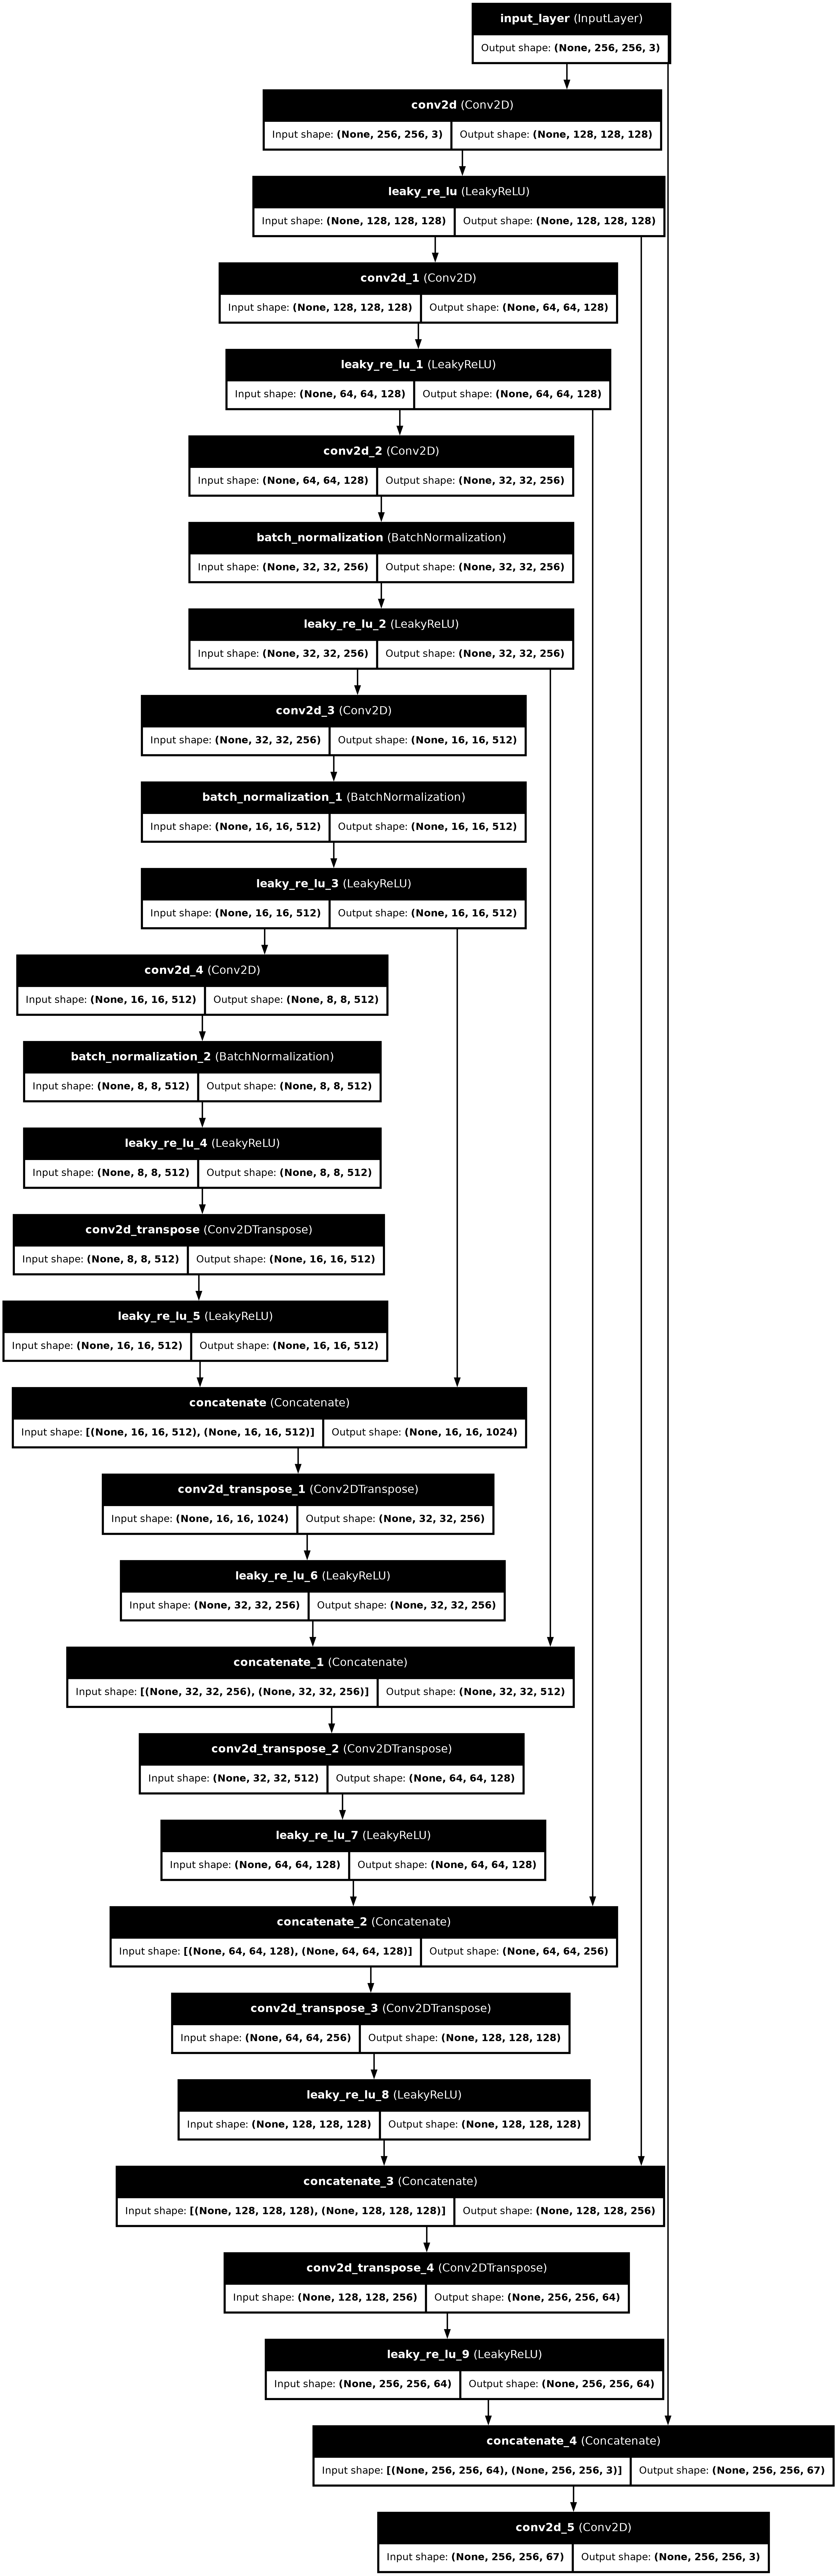

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
model.compile(
    optimizer = optimizers.Adam(learning_rate=0.001),
    loss = "mean_absolute_error",
    metrics = ["accuracy"]
)

# Train

In [19]:
history = model.fit(
    train_low_images,
    train_high_images,
    epochs = 100,
    batch_size = 16,
    validation_data=(test_low_images, test_high_images),
    verbose = 1
)

Epoch 1/100


I0000 00:00:1741246960.373782   98621 service.cc:148] XLA service 0x74b65c09ba30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741246960.373817   98621 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
I0000 00:00:1741246960.964029   98621 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1741246980.333634   98621 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.4622 - loss: 0.1604 - val_accuracy: 0.5670 - val_loss: 0.1695
Epoch 2/100


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/saumitra/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/saumitra/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/saumitra/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3099, in _run_cell

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3303, in run_cell_async

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3486, in run_ast_nodes

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3546, in run_code

  File "/tmp/ipykernel_97922/1287469802.py", line 1, in <module>

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/saumitra/College/PBL2/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 1540467688 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_5607]

In [20]:
model.save("diffusion.keras")

# Results

In [23]:
history_df = pd.DataFrame(history.history)
history_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.477053,0.148859,0.539638,0.182542
1,0.543914,0.129361,0.589257,0.169610
2,0.602745,0.124257,0.659365,0.163449
3,0.644212,0.119566,0.687949,0.145493
4,0.681182,0.118229,0.719462,0.143052


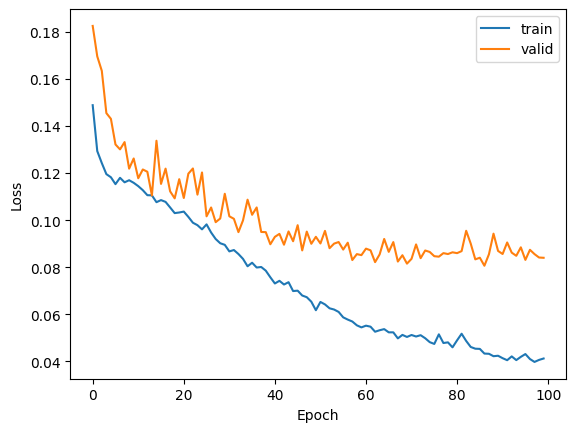

In [24]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.show()

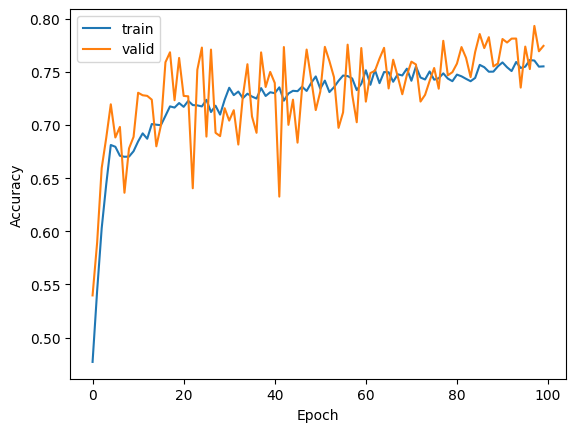

In [25]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.show()

In [26]:
def predict_images(test_low, test_high, count=5, size=224):
    for _ in range(count):
        random_idx = np.random.randint(len(test_low))
        predicted = model.predict(test_low[random_idx].reshape(1, size, size, 3), verbose=0)
        predicted = np.clip(predicted, 0.0, 1.0).reshape(size, size, 3)
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
        
        axes[0].imshow(test_low[random_idx])
        axes[0].set_title("Low-Light Image")
        axes[0].axis("off")
        
        axes[1].imshow(test_high[random_idx])
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        axes[2].imshow(predicted)
        axes[2].set_title("Enhanced Image")
        axes[2].axis("off")
        
        plt.show()

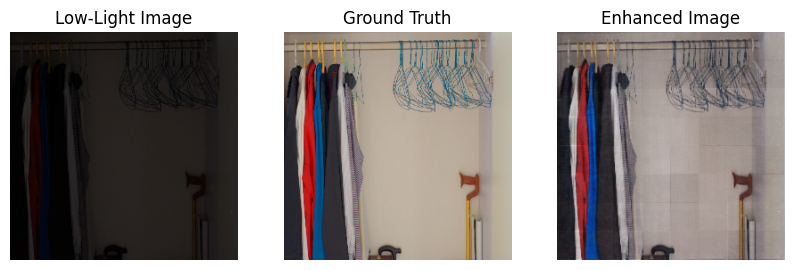

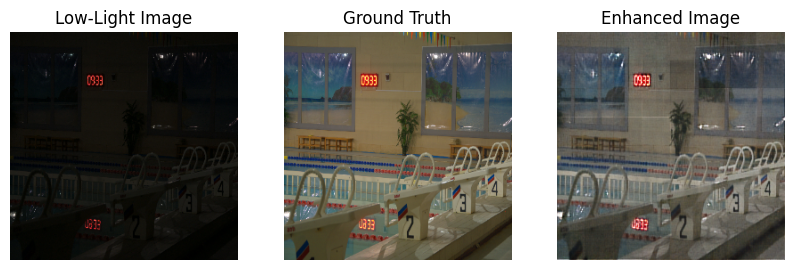

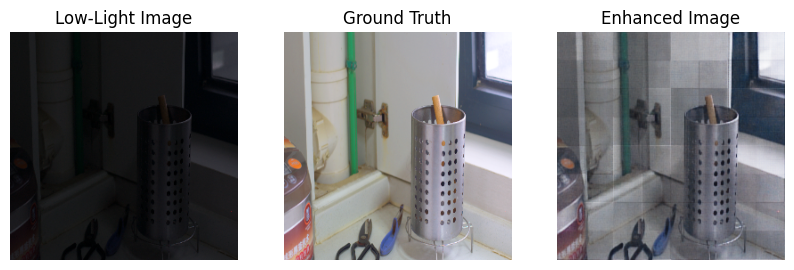

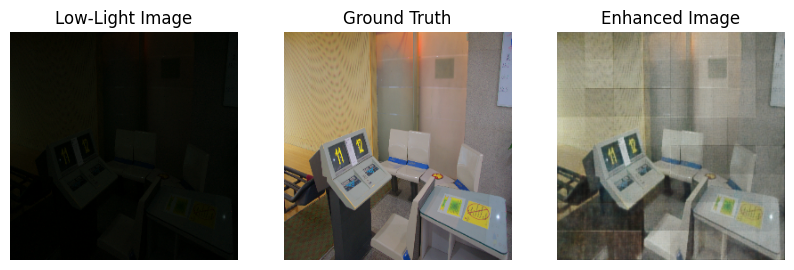

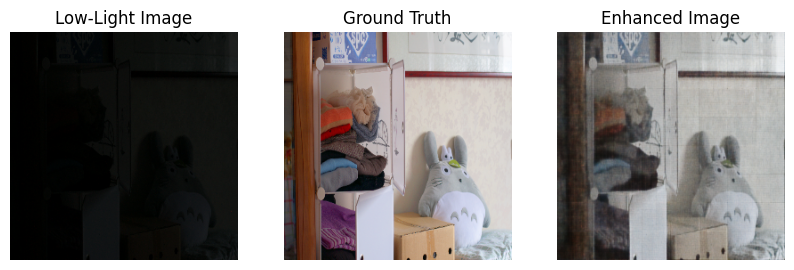

In [28]:
predict_images(test_low_images, test_high_images, count=5, size=SIZE)